In [19]:
# Import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier

from sklearn.utils.class_weight import compute_sample_weight

from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB

from sklearn.linear_model import LogisticRegression

from sklearn.utils.class_weight import compute_sample_weight

df_crashes = pd.read_csv('data/Traffic_Crashes_-_Crashes.csv', index_col='CRASH_RECORD_ID')
df_people = pd.read_csv('data/Traffic_Crashes_-_People.csv', index_col='CRASH_RECORD_ID')
df_vehicles = pd.read_csv('data/Traffic_Crashes_-_Vehicles.csv', index_col='CRASH_RECORD_ID')

/Users/lindstromkyle/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (20,24,25,26,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/lindstromkyle/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
#Here we are dropping columns either not relevant, too difficult to work with, or repetitive. 
crashes_columns_drop = df_crashes[['CRASH_DATE', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'RD_NO', 'CRASH_DATE_EST_I', 'DATE_POLICE_NOTIFIED','TRAFFIC_CONTROL_DEVICE',
                                   'DEVICE_CONDITION', 'STREET_NO',
                        'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE','PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 
                        'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'LANE_CNT','REPORT_TYPE', 'CRASH_MONTH','LATITUDE',
                        'LONGITUDE','LOCATION','INJURIES_TOTAL','INJURIES_FATAL', 'INJURIES_INCAPACITATING','INJURIES_NON_INCAPACITATING',
                        'INJURIES_REPORTED_NOT_EVIDENT','INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN','CRASH_MONTH','TRAFFICWAY_TYPE',
                        'PRIM_CONTRIBUTORY_CAUSE','SEC_CONTRIBUTORY_CAUSE','NOT_RIGHT_OF_WAY_I','HIT_AND_RUN_I','INTERSECTION_RELATED_I']]

vehicles_columns_drop = df_vehicles[['RD_NO', 'CRASH_DATE', 'LIC_PLATE_STATE', 'AREA_00_I', 'AREA_01_I', 
                                       'AREA_02_I', 'AREA_03_I','AREA_04_I','AREA_05_I','AREA_06_I','AREA_07_I',
                                       'AREA_08_I','AREA_09_I','AREA_10_I','AREA_11_I','AREA_12_I','AREA_99_I',
                                       'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO', 'COMMERCIAL_SRC', 'GVWR',
                                       'CARRIER_NAME', 'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO',
                                       'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO', 'MCS_REPORT_I', 
                                       'IDOT_PERMIT_NO', 'WIDE_LOAD_I', 'TRAILER1_WIDTH', 'TRAILER2_WIDTH', 'TRAILER1_LENGTH', 
                                       'TRAILER2_LENGTH', 'TOTAL_VEHICLE_LENGTH', 'AXLE_CNT', 'LOAD_TYPE', 'HAZMAT_OUT_OF_SERVICE_I',
                                        'MCS_OUT_OF_SERVICE_I', 'HAZMAT_CLASS', 'MAKE', 'MODEL', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 
                                       'VEHICLE_CONFIG', 'CARGO_BODY_TYPE', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY', 'TOWED_I', 'CARRIER_STATE',
                                       'FIRE_I', 'MCS_REPORT_NO','HAZMAT_VIO_CAUSE_CRASH_I','MCS_VIO_CAUSE_CRASH_I', 'TOWED_TO',
                                        'CMRC_VEH_I','VEHICLE_ID', 'OCCUPANT_CNT', 'NUM_PASSENGERS', 'TRAVEL_DIRECTION', 'MANEUVER',
                                       'VEHICLE_USE', 'CRASH_UNIT_ID', 'UNIT_TYPE']]

people_columns_drop = df_people[['RD_NO', 'CRASH_DATE', 'CITY', 'STATE', 'ZIPCODE', 'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS',
                       'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION',
                       'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE', 'CELL_PHONE_USE']]



df_crashes.drop(columns=crashes_columns_drop, inplace=True)
df_vehicles.drop(columns=vehicles_columns_drop, inplace=True)
df_people.drop(columns=people_columns_drop, inplace=True)

In [3]:
#Here we are mapping and applying functions for the columns that we are going to use from the vehicle DF
contact_map = {
    'FRONT': 'Front',                
    'OTHER' : 'Unknown',                
    'REAR-LEFT' : 'Rear',           
    'UNKNOWN' : 'Unknown',              
    'REAR' : 'Rear',                 
    'FRONT-LEFT' : 'Front',            
    'FRONT-RIGHT' : 'Front',            
    'TOTAL (ALL AREAS)' : 'Total',    
    'SIDE-RIGHT' : 'Side',           
    'SIDE-LEFT' : 'Side',          
    'ROOF' : 'Roof',                  
    'REAR-RIGHT' :'Roof',            
    'UNDER CARRIAGE' : 'Under',
    'NONE' : 'Unknown'
}

df_vehicles['Contact_Point'] = df_vehicles['FIRST_CONTACT_POINT'].map(contact_map)
df_vehicles.drop('FIRST_CONTACT_POINT', axis=1, inplace=True)

def label_vehicletype(row):
    if row['VEHICLE_TYPE'] in ['PASSENGER']:
        return 'Car'
    elif row['VEHICLE_TYPE'] in ['SPORT UTILITY VEHICLE (SUV)', 'VAN/MINI-VAN']:
        return 'SUV'
    elif row['VEHICLE_TYPE'] in ['PICKUP','TRUCK - SINGLE UNIT','SINGLE UNIT TRUCK WITH TRAILER']:
        return 'Truck'
    elif row['VEHICLE_TYPE'] in ['BUS OVER 15 PASS.','TRACTOR W/ SEMI-TRAILER','BUS UP TO 15 PASS.', 'OTHER VEHICLE WITH TRAILER', 'TRACTOR W/O SEMI-TRAILER']:
        return 'Large_vehicle'
    elif row['VEHICLE_TYPE'] in ['MOTORCYCLE (OVER 150CC)','AUTOCYCLE','MOPED OR MOTORIZED BICYCLE', 'MOTOR DRIVEN CYCLE', 'ALL-TERRAIN VEHICLE (ATV)', 
                                 '3-WHEELED MOTORCYCLE (2 REAR WHEELS)', 'RECREATIONAL OFF-HIGHWAY VEHICLE (ROV)']:
        return 'Motorcycle'
    elif row['VEHICLE_TYPE'] in ['UNKNOWN/NA','OTHER','SNOWMOBILE', 'FARM EQUIPMENT']:
        return 'Unknown'
df_vehicles['VEHICLE_TYPE'] = df_vehicles.apply(lambda row: label_vehicletype(row), axis=1)

In [4]:
#Here we are setting up our people df
#handling ages
Age_Series = df_people.groupby(['CRASH_RECORD_ID'])[['AGE']].agg('median')
#handling people count
Person_Count_Series = df_people.groupby(['CRASH_RECORD_ID'])[['SEX']].agg('count')
Person_Count_Series.rename(columns = {'SEX' : 'PERSON_COUNT'}, inplace = True)
#handling airbag
Airbag_Series = df_people.groupby(['CRASH_RECORD_ID'])[['AIRBAG_DEPLOYED']].first()
Airbag_Series = pd.DataFrame(Airbag_Series['AIRBAG_DEPLOYED'].str.contains('DEPLOYED'))
#handling safety 
Safety_Series = df_people.groupby(['CRASH_RECORD_ID'])[['SAFETY_EQUIPMENT']].first()
equipment_list = ['NONE PRESENT','SAFETY BELT NOT USED','HELMET NOT USED','NOT DOT COMPLIANT MOTORCYCLE HELMET',
                  'SHOULD/LAP BELT USED IMPROPERLY','CHILD RESTRAINT NOT USED','CHILD RESTRAINT USED IMPROPERLY']
Safety_Series['BOOL'] = pd.DataFrame( (Safety_Series['SAFETY_EQUIPMENT'].isin(equipment_list)))

Safety_Series["BOOL"] =  ~Safety_Series["BOOL"]
Safety_Series.loc[Safety_Series['SAFETY_EQUIPMENT'] == 'USAGE UNKNOWN', ['BOOL']] = 'Unknown'
Safety_Series = Safety_Series[['BOOL']]
Safety_Series.rename(columns = {'BOOL' : 'SAFETY_EQUIPMENT'}, inplace = True)

In [5]:
#merging our people series to crashes df
df_crashes_people = df_crashes.merge(Age_Series, how='inner', on='CRASH_RECORD_ID').merge(Person_Count_Series, how='inner', on='CRASH_RECORD_ID').merge(Airbag_Series, how='inner', on='CRASH_RECORD_ID').merge(Safety_Series, how='inner', on='CRASH_RECORD_ID')
#pivoting our vehicles df for merging
pivot = pd.pivot_table(df_vehicles, columns ='UNIT_NO', index='CRASH_RECORD_ID', values ='VEHICLE_TYPE', aggfunc = 'first')
pivot2 = pd.pivot_table(df_vehicles, columns = 'UNIT_NO', index='CRASH_RECORD_ID', values = 'Contact_Point', aggfunc = 'first')
#merging our vehicle and crashes/people df to create maindf
df_main = df_crashes_people.merge(pivot.iloc[:,1:3], how='inner', on='CRASH_RECORD_ID').merge(pivot2.iloc[:,1:3], how='inner', on='CRASH_RECORD_ID')

In [6]:
df_main['FATAL/INCAPACITATING_INJURY'] = True

injury_list = ['NO INDICATION OF INJURY','NONINCAPACITATING INJURY','REPORTED, NOT EVIDENT']

df_main.loc[(df_main['MOST_SEVERE_INJURY'].isin(injury_list)) | (df_main['MOST_SEVERE_INJURY'].isna()), ['FATAL/INCAPACITATING_INJURY']] = False
df_main = df_main.drop('MOST_SEVERE_INJURY', axis = 1)


In [7]:
def label_weather(row):
    if row['WEATHER_CONDITION'] in ['RAIN', 'SNOW','FREEZING RAIN/DRIZZLE','SLEET/HAIL','BLOWING SNOW']:
        return 'RAIN/SNOW'
    elif row['WEATHER_CONDITION'] in ['CLOUDY/OVERCAST', 'FOG/SMOKE/HAZE', 'SEVERE CROSS WIND GATE', 'BLOWING SAND, SOIL, DIRT','OTHER']:
        return 'OTHER'
    elif row['WEATHER_CONDITION'] in ['CLEAR']:
        return 'CLEAR'
    elif row['WEATHER_CONDITION'] in ['UNKNOWN']:
        return 'UNKNOWN'


df_main['WEATHER_CONDITION'] = df_main.apply(lambda row: label_weather(row), axis=1)

def label_crashtype(row):
    if row['FIRST_CRASH_TYPE'] in ['PARKED MOTOR VEHICLE','FIXED OBJECT','REAR TO REAR','REAR TO SIDE','ANIMAL','OTHER OBJECT']:
        return 'PARKED/OBJECT/SLOW'
    elif row['FIRST_CRASH_TYPE'] in ['REAR END', 'SIDESWIPE SAME DIRECTION', 'REAR TO FRONT']:
        return 'SAME DIRECTION'
    elif row['FIRST_CRASH_TYPE'] in ['HEAD ON','OVERTURNED','TRAIN']:
        return 'HEAD ON/OVERTURNED/TRAIN'
    elif row['FIRST_CRASH_TYPE'] in ['TURNING','ANGLE','SIDESWIPE OPPOSITE DIRECTION']:
        return 'ANGEL/SIDE'
    elif row['FIRST_CRASH_TYPE'] in ['PEDESTRIAN','PEDALCYCLIST','SIDESWIPE OPPOSITE DIRECTION']:
        return 'PEDESTRIAN/CYCLIST'


df_main['FIRST_CRASH_TYPE'] = df_main.apply(lambda row: label_crashtype(row), axis=1)


df_main['ALIGNMENT'] = df_main['ALIGNMENT'].apply(lambda x: 'STRAIGHT AND LEVEL' if x == 'STRAIGHT AND LEVEL' else 'NOT STRAIGHT AND LEVEL')
df_main['LIGHTING_CONDITION'] = df_main['LIGHTING_CONDITION'].apply(lambda x: 'TWILIGHT' if x == 'DUSK' or x == 'DAWN' else x)
df_main['ROADWAY_SURFACE_COND'] = df_main['ROADWAY_SURFACE_COND'].apply(lambda x: 'OTHER' if x == 'SNOW OR SLUSH' or x == 'ICE' or x =='SAND, MUD, DIRT' else x)
df_main['ROAD_DEFECT'] = df_main['ROAD_DEFECT'].apply(lambda x: 'DEFECT' if x == 'RUT, HOLES' or x == 'OTHER' or x =='WORN SURFACE' or x == 'SHOULDER DEFECT' or x == 'DEBRIS ON ROADWAY' else x)

df_main['SAFETY_EQUIPMENT'] = df_main['SAFETY_EQUIPMENT'].apply(lambda x: 'Yes' if x == True else x)
df_main['SAFETY_EQUIPMENT'] = df_main['SAFETY_EQUIPMENT'].apply(lambda x: 'No' if x == False else x)

df_main['AIRBAG_DEPLOYED'] = df_main['AIRBAG_DEPLOYED'].apply(lambda x: 'Yes' if x == True else x)
df_main['AIRBAG_DEPLOYED'] = df_main['AIRBAG_DEPLOYED'].apply(lambda x: 'No' if x == False else x)

df_main['FATAL/INCAPACITATING_INJURY'] = df_main['FATAL/INCAPACITATING_INJURY'].apply(lambda x: 1 if x == True else x)
df_main['FATAL/INCAPACITATING_INJURY'] = df_main['FATAL/INCAPACITATING_INJURY'].apply(lambda x: 0 if x == False else x)

df_main['DAMAGE'] = df_main['DAMAGE'].apply(lambda x: 'OVER $1,500' if x == 'OVER $1,500' else 'UNDER $1,500')


unit_map = {
    1 : '1',                
    2 : '2',                
    3 : '3 or more',           
    4 : '3 or more',              
    5 : '3 or more',                 
    6 : '3 or more',            
    7 : '3 or more',            
    8 : '3 or more',    
    9 : '3 or more',           
    10 : '3 or more',         
    11 : '3 or more',                  
    12 :'3 or more',            
    14 : '3 or more',
    15 : '3 or more',
    16 : '3 or more',
    18 : '3 or more',
}

df_main['NUM_UNITS'] = df_main['NUM_UNITS'].map(unit_map)

def label_speed_limits(row):
    if row['POSTED_SPEED_LIMIT'] <= 10:
        return '0 to 10 mph'
    elif row['POSTED_SPEED_LIMIT']  <= 20:
        return '11 to 20mph'
    elif row['POSTED_SPEED_LIMIT'] <= 30:
        return '21 to 30mph'
    elif row['POSTED_SPEED_LIMIT'] <= 40:
        return '31 to 40mph'
    elif row['POSTED_SPEED_LIMIT'] <= 50:
        return '41 to 50mph'
    elif row['POSTED_SPEED_LIMIT'] <= 60:
        return '51 to 60mph'
    elif row['POSTED_SPEED_LIMIT'] >= 61:
        return '61mph and over'

df_main['POSTED_SPEED_LIMIT'] = df_main.apply(lambda row: label_speed_limits(row), axis=1) 

def label_personcount(row):
    if row['PERSON_COUNT'] == 1:
        return 'One'
    elif row['PERSON_COUNT']  == 2:
        return 'Two'
    elif row['PERSON_COUNT'] == 3:
        return 'Three'
    elif row['PERSON_COUNT'] == 4:
        return 'Four'
    elif row['PERSON_COUNT'] >= 5:
        return 'Five or more'
    
df_main['PERSON_COUNT'] = df_main.apply(lambda row: label_personcount(row), axis=1) 


df_main['Vehicle1'] = df_main['1_x']
df_main['Vehicle2'] = df_main['2_x']
df_main['Contact1'] = df_main['1_y']
df_main['Contact2'] = df_main['2_y']
df_main = df_main.drop(['1_x', '2_x', '1_y', '2_y'], axis=1)

In [8]:
df_main = df_main.dropna(subset = ['PERSON_COUNT', 'FIRST_CRASH_TYPE','AIRBAG_DEPLOYED', 'Vehicle1', 'Vehicle2', 'Contact1', 'Contact2'], axis = 0)

In [9]:
model = df_main.copy()

In [10]:
X = model.drop('FATAL/INCAPACITATING_INJURY', axis = 1)
y = model['FATAL/INCAPACITATING_INJURY']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=.2)

Dummy Classifier TEST Recall Score: 0.0
Dummy Classifier TEST Precision Score: 0.0
Dummy Classifier TEST F1 Score: 0.0
Dummy Classifier TEST Accuracy Score: 0.9893918508180861


/Users/lindstromkyle/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


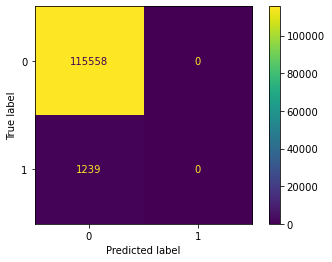

In [11]:
dummy = DummyClassifier(strategy = 'most_frequent')

dummy.fit(X_train,y_train)

plot_confusion_matrix(dummy, X_test, y_test)

print('Dummy Classifier TEST Recall Score:', recall_score(y_test,dummy.predict(X_test)))
print('Dummy Classifier TEST Precision Score:', precision_score(y_test,dummy.predict(X_test)))
print('Dummy Classifier TEST F1 Score:', f1_score(y_test,dummy.predict(X_test)))
print('Dummy Classifier TEST Accuracy Score:', accuracy_score(y_test,dummy.predict(X_test)))

In [12]:
num = ['AGE']
cat = ['POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
      'ROAD_DEFECT', 'CRASH_TYPE', 'NUM_UNITS', 'PERSON_COUNT', 'AIRBAG_DEPLOYED', 'SAFETY_EQUIPMENT', 'Vehicle1', 'Vehicle2',
      'Contact1', 'Contact2', 'DAMAGE']

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'median'))])

cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown = "ignore"))])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num),
                                               ('cat', cat_transformer, cat)])

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LogisticRegression(class_weight ='balanced', max_iter=850))])

pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['POSTED_SPEED_LIMIT',
                                                   'WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_CON

In [14]:
y_hat_train = pipe.predict(X_train)
y_hat_test = pipe.predict(X_test)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.05126982118347918
Testing Precision:  0.047672310718555946



Training Recall:  0.9982941622441244
Testing Recall:  0.9975786924939467



Training Accuracy:  0.7913619171766337
Testing Accuracy:  0.7885733366439206



Training F1-Score:  0.09753071560176656
Testing F1-Score:  0.09099609806375616


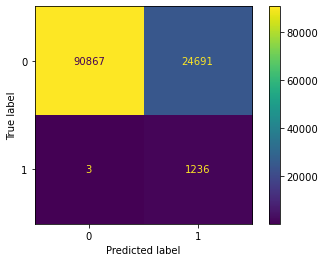

In [15]:
plot_confusion_matrix(pipe, X_test, y_test)

In [16]:
#Best params from this are 'classiffier__penalty': 'l2', 'classiffier__solver': 'sag', this decreased performance just a default logreg model

#grid = [{
#    'classiffier__penalty': ['none', 'l2', 'elasticnet'],
#    'classiffier__solver' : ['sag', 'saga', 'newton-cg', 'lbfgs']
#}]


#logreg = GridSearchCV(estimator=pipe, param_grid=grid, cv=5)
#logreg.fit(X_train, y_train)

#logreg.best_params_

In [17]:
#pipe.get_params().keys()

Training Precision:  0.05103402913466561
Testing Precision:  0.04756050710718402



Training Recall:  1.0
Testing Recall:  0.9991928974979822



Training Accuracy:  0.7900069993385946
Testing Accuracy:  0.7877257121330171



Training F1-Score:  0.09711203961052108
Testing F1-Score:  0.09079907587370274


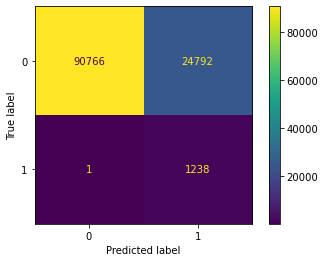

In [51]:
#sample_weights = compute_sample_weight(class_weight='balanced', y = y_train)

pipe_boost = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', XGBClassifier(max_depth = 4, eta = 0.1, scale_pos_weight = 700,  tree_method = 'hist' ))])

pipe_boost.fit(X_train,y_train) #, classifier__sample_weight = sample_weights)

y_hat_train = pipe_boost.predict(X_train)
y_hat_test = pipe_boost.predict(X_test)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))


plot_confusion_matrix(pipe_boost, X_test, y_test);

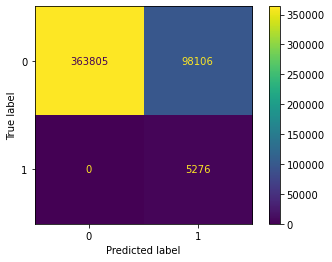

In [52]:
plot_confusion_matrix(pipe_boost, X_train, y_train);